# GNN for node classification

Train a GNN on the node classification task to decide whether tracksters in a neighborhood of a selected trackster belong to the same simtrackster. For a detailed description of the methods, refer to the [Master Thesis Text](https://www.merlin.uzh.ch/publication/show/23612).

### Problem setup

This notebook covers preprocessing the ROOT files into PyTorch datasets, model training, and evaluation against the baselines. ONNX export for the graph models is currently not supported due to `torch_cluster` ONNX implementation missing. The reconstruction process consists of the following steps:

### Dataset preprocessing

First, the ROOT files are preprocessed into a PyTorch dataset.

#### 1. Select tracksters above a certain energy threshold

Select a high-energy trackster to run the smoothing around. The energy threshold is a fine-tined parameter. Generally, 5 - 20 GeV was found to work well. This notebook covers the pile-up scenario, where simtracksters are only present for selected particle showers in the event. Therefore, only tracksters with at least 50% energy coming from the examined simtracksters are considered in training.

**Result**: Selected Tracksters.

#### 2. Get tracksters in the cylindrical neighborhood of Selected Tracksters

The cylinder is defined along the axis connecting the trackster barycenter to 0,0,0 and a selected radius (e.g., 15cm). Tracksters within this radius are considered the Candidate Tracksters.

**Result**: Event sub-graphs around the Selected Trackster

### Model training

The model is trained on sub-graphs representing a Selecter Trackster and its neighborhood. The learning task is to predict whether each trackster in the set belongs to the same class as the Selected Trackster (the *foreground* class). The model is based on the ParticleNet architecture, with the first block of EdgeConv considering the neighbors in the trackster barycenter space. Then, the two following EdgeConv blocks are dynamic and search for nearest neighbors in the latent spaces. Finally, the foreground and background class prediction error is combined in `GraphClassificationLoss`; see `reco.loss` for implementation and the [Master Thesis Text](https://www.merlin.uzh.ch/publication/show/23612) for theoretical background.

### Inference event reconstruction

In inference, the class labels are predicted for all neighborhoods of Selected Tracksters. Overlapping foreground classes are merged if they share more than half of their energies.

#### Evaluation

The improvement in the event reconstruction is evaluated using B-CUBED metrics and compared against the baselines.

## Data location

Set `ds_name` to the dataset name, and point `raw_dir` to the directory containing ntuplized `.root` files.
Processed `PyTorch` datasets will be placed in the `data_root` folder. The program will verify if the requested datasets exist already. Make sure the directories exist.

In [1]:
ds_name = "CloseByPion200PU"
raw_dir = "/home/ecuba/data/CloseByPion200PU"
data_root = "/home/ecuba/data/processed"
model_dir = "/home/ecuba/data/models"

## Initialization

In [2]:
import numpy as np
import torch
import sys

import matplotlib.pyplot as plt

import torch.nn as nn
from torch.optim import Adam
from torch_cluster import knn_graph
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

from reco.model import EdgeConvBlock, DynamicEdgeConvBlock

from reco.training import precision_recall_curve, roc_auc, train_graph_classification, test_graph_classification
from reco.loss import GraphClassificationLoss
from reco.dataset_graph import TracksterGraph

import torch_geometric.nn as gnn

In [3]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load or process the dataset

At least `N_FILES=100` root files is recommended to have a large enough training sample.
The following parameters need to be set:
- `bigT_e_th`: energy threshold to select tracksters for smoothing
- `radius`: radius of the cylinder around the selected tracksters
- `pileup`: needs to be set to `true` for pile-up datasets, the selection of the tracksters is limited to ones that overlap with a simtrackster
- `link_prediction`: controls the problem setup, should be set to `False` for node classification

The following cell will load (if available) or preprocess the root files into a PyTorch dataset. See the class `TracksterGraph` for more details.

In [4]:
def knn_transform(data):
    """
    Find nearest neighbors in the cartesian space
    """
    data.edge_index = knn_graph(data.pos, k=8, loop=False)
    return data

# can be done in pre-processing, but we do this manually in the model
transforms = T.Compose([knn_transform])

ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=400,
    radius=15,
    bigT_e_th=5,
)
ds

TracksterGraphPU(graphs=28123, nodes=758118, radius=15, bigT_e_th=5)

## Split the dataset into train and validation

In [5]:
val_set_fraction = 0.1

ds_size = len(ds)
val_set_size = ds_size // int(1. / val_set_fraction)
train_set_size = ds_size - val_set_size
train_set, val_set = random_split(ds, [train_set_size, val_set_size])
print(f"Train sub-graphs: {len(train_set)}, Validation sub-graphs: {len(val_set)}")

train_dl = DataLoader(train_set, batch_size=8, shuffle=True)
val_dl = DataLoader(val_set, batch_size=8, shuffle=True)

Train sub-graphs: 25311, Validation sub-graphs: 2812


## Model configuration

Configure model and training setup. Here, we use a ParticleNet inspired model with three EdgeConv blocks followed by two dense layers.
The first EdgeConv block is using a k-nn based on the trackster barycenters, the remaining two layers compute the nearest neighbors in the latent space.
The output is class probability vector for the foreground and background for each trackster (graph node).

If training on `N_FILES=400`, the model tends to overfit on `100` epochs, in this training configuration `50` epochs is recommended.

In [6]:
class TracksterGraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=2, dropout=0.2):
        super(TracksterGraphNet, self).__init__()

        self.norm = gnn.LayerNorm(input_dim)
        
        hdim1 = 32
        hdim2 = 64
        hdim3 = 64
        hdim_fc = 128

        self.input_edgeconv = EdgeConvBlock(input_dim, hdim1)
        self.edgeconv1 = DynamicEdgeConvBlock(hdim1, hdim2, k=8)
        self.edgeconv2 = DynamicEdgeConvBlock(hdim2, hdim3, k=8)
        
        # Edge features from node embeddings for classification        
        self.nodenetwork = nn.Sequential(
            nn.Linear(hdim3, hdim_fc),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, output_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, X, pos, batch=None):
        edge_index = knn_graph(pos, batch=batch, k=8, loop=False)
        H0 = self.input_edgeconv(X, edge_index)
        H1 = self.edgeconv1(H0, batch)
        H2 = self.edgeconv2(H1, batch)
        return self.nodenetwork(H2).squeeze(-1)

In [7]:
model = TracksterGraphNet(input_dim=ds.x.shape[1], output_dim=2)
epochs = 51
model_path = f"{model_dir}/TracksterGraphNet.{epochs}e-{ds_name}.r{ds.RADIUS}.e{ds.bigT_e_th}.f{ds.N_FILES}.pt"

## Training

Train the model and compute validation loss.

In [12]:
# skip this cell if loading a pre-trained model
loss_func = GraphClassificationLoss()

model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)

for epoch in range(epochs):

    train_loss = train_graph_classification(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    scheduler.step()

    if epoch % 5 == 0:
        test_loss = test_graph_classification(model, device, loss_func, val_dl)
        print(
            f"Epoch {epoch}:\t train loss: {train_loss:.3f}\t validation loss: {test_loss:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)
print(model_path)

Epoch 0:	 train loss: 2207.441	 validation loss: 218.752
Epoch 5:	 train loss: 1621.462	 validation loss: 184.618
Epoch 10:	 train loss: 1511.281	 validation loss: 193.576
Epoch 15:	 train loss: 1446.549	 validation loss: 163.464
Epoch 20:	 train loss: 1408.163	 validation loss: 157.162
Epoch 25:	 train loss: 1363.431	 validation loss: 149.991
Epoch 30:	 train loss: 1326.799	 validation loss: 155.675
Epoch 35:	 train loss: 1289.179	 validation loss: 154.033
Epoch 40:	 train loss: 1264.817	 validation loss: 149.450
Epoch 45:	 train loss: 1250.763	 validation loss: 148.018


/home/ecuba/data/models/TracksterGraphNet.51e-CloseByPion200PU.r15.e5.f400.pt


Epoch 50:	 train loss: 1243.256	 validation loss: 148.455


In [8]:
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

0.9434556884341958


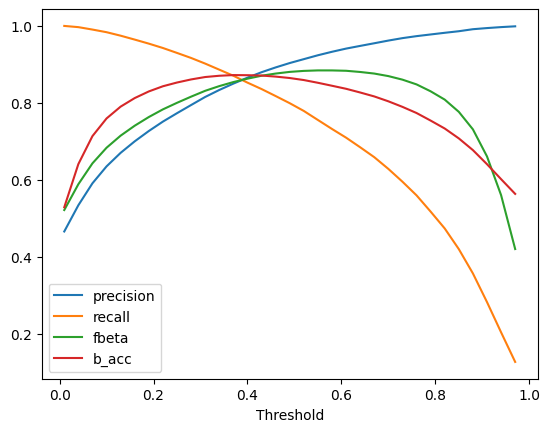

TP: 25973, TN: 39716, FP: 2154, FN: 8418
TH: 0.55 precision: 0.923 recall: 0.755 fbeta: 0.884 b_acc: 0.852


In [18]:
print(roc_auc(model, device, val_dl))
precision_recall_curve(model, device, val_dl, step=3, truth_threshold=0.5)

## Evaluation

Evaluate the model performance on an unseen set of events across different radius settings.
For each selected trackster (energy above threshold), classify all tracksters in the cylindrical neighborhood as "foreground" or "background", creating foreground supertracksters.
If two foreground overlap by more than half of their energies, they are merged into one.

In [9]:
from reco.data import get_event_data
from reco.evaluation import model_evaluation

file_name = f"{raw_dir}/test/test_samples_1.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name)

In [10]:
r_ranges = [3, 5, 10, 15]
results = []

max_events = 20
clue3D_F = []
target_F = []
model_reco_F = []
for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")

    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model,
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        bigT_e_th=5,
        pileup=True,
        graph=True,
    )
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

 --- Radius threshold: 3 ---
Event 0:
	clue3d_to_sim:	P: 0.945 R: 0.198 F: 0.538
	target_to_sim:	P: 0.945 R: 0.198 F: 0.538
	reco_to_sim:	P: 0.945 R: 0.198 F: 0.538
	|Sim| = 1 |Target| = 2 |Reco| = 2
Event 1:
	No data
Event 2:
	clue3d_to_sim:	P: 0.916 R: 0.321 F: 0.668
	target_to_sim:	P: 0.911 R: 0.342 F: 0.684
	reco_to_sim:	P: 0.911 R: 0.342 F: 0.684
	|Sim| = 1 |Target| = 2 |Reco| = 2
Event 3:
	clue3d_to_sim:	P: 0.969 R: 0.706 F: 0.902
	target_to_sim:	P: 0.969 R: 0.706 F: 0.902
	reco_to_sim:	P: 0.969 R: 0.706 F: 0.902
	|Sim| = 1 |Target| = 4 |Reco| = 4
Event 4:
	clue3d_to_sim:	P: 0.535 R: 0.483 F: 0.523
	target_to_sim:	P: 0.535 R: 0.483 F: 0.523
	reco_to_sim:	P: 0.535 R: 0.483 F: 0.523
	|Sim| = 1 |Target| = 1 |Reco| = 1
Event 5:
	clue3d_to_sim:	P: 1.000 R: 0.262 F: 0.639
	target_to_sim:	P: 1.000 R: 0.282 F: 0.663
	reco_to_sim:	P: 1.000 R: 0.282 F: 0.663
	|Sim| = 1 |Target| = 6 |Reco| = 6
Event 6:
	clue3d_to_sim:	P: 1.000 R: 0.857 F: 0.968
	target_to_sim:	P: 1.000 R: 0.857 F: 0.968
	re

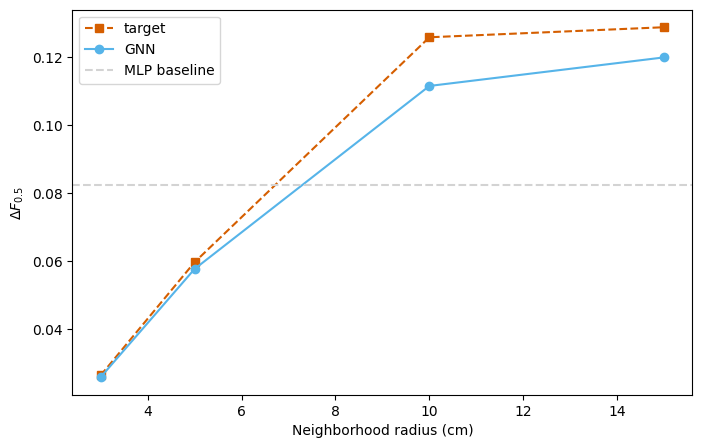

In [11]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(r_ranges[:6], (np.array(target_F) - np.array(clue3D_F))[:6], '--s', label="target", c="#D55E00")
ax.plot(r_ranges[:6], (np.array(model_reco_F) - np.array(clue3D_F))[:6], '-o', label="GNN", c="#56B4E9")
ax.axhline(0.0825, label="MLP baseline", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")

plt.show()